In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving fertilizer_recommendation_dataset.csv to fertilizer_recommendation_dataset.csv


In [3]:
import pandas as pd
df_fertilizer = pd.read_csv('fertilizer_recommendation_dataset.csv')
print(df_fertilizer.head())

   Temperature  Moisture    Rainfall        PH   Nitrogen  Phosphorous  \
0    50.179845  0.725893  205.600816  6.227358  66.701872    76.963560   
1    21.633318  0.721958  306.081601  7.173131  71.583316   163.057636   
2    23.060964  0.685751  259.336414  7.380793  75.709830    62.091508   
3    26.241975  0.755095  212.703513  6.883367  78.033687   151.012521   
4    21.490157  0.730672  268.786767  7.578760  71.765123    66.257371   

    Potassium    Carbon        Soil  Crop                  Fertilizer  \
0   96.429065  0.496300  Loamy Soil  rice                     Compost   
1  148.128347  1.234242  Loamy Soil  rice     Balanced NPK Fertilizer   
2   80.308971  1.795650  Peaty Soil  rice  Water Retaining Fertilizer   
3  153.005712  1.517556  Loamy Soil  rice     Balanced NPK Fertilizer   
4   97.000886  1.782985  Peaty Soil  rice          Organic Fertilizer   

                                              Remark  
0  Enhances organic matter and improves soil stru...  
1  Pro

In [4]:
f = df_fertilizer.drop('Fertilizer', axis=1)

t = df_fertilizer['Fertilizer']

In [5]:
labels = df_fertilizer['Fertilizer'].unique()
print(labels)

['Compost' 'Balanced NPK Fertilizer' 'Water Retaining Fertilizer'
 'Organic Fertilizer' 'Gypsum' 'Lime' 'DAP' 'Urea' 'Muriate of Potash'
 'General Purpose Fertilizer']


In [6]:
categorical_cols = [col for col in f.columns if f[col].dtype == 'object']
print(categorical_cols)

['Soil', 'Crop', 'Remark']


In [7]:
categorical_cols = [col for col in f.columns if f[col].dtype == 'object']
for col in categorical_cols:
    mapping = {val: idx for idx, val in enumerate(f[col].unique())}
    f[col] = f[col].map(mapping)

f = f.apply(pd.to_numeric, errors='raise')
f = f.to_numpy()

In [8]:
unique_labels = sorted(df_fertilizer['Fertilizer'].unique())
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
t = df_fertilizer['Fertilizer'].map(label_mapping).to_numpy()

In [9]:
def mskf(f, t, k=10, seed=42):
    np.random.seed(seed)
    folds = [[] for _ in range(k)]
    unique_classes = np.unique(t)
    class_indices = {label: np.where(t == label)[0] for label in unique_classes}
    for label in unique_classes:
        np.random.shuffle(class_indices[label])
        split_indices = np.array_split(class_indices[label], k)
        for fold_idx, split in enumerate(split_indices):
            folds[fold_idx].extend(split)
    return [np.array(fold) for fold in folds]

In [11]:
class NB_HW2:
    def __init__(self, alpha):
        self.alpha = alpha

    def fitting(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0) + self.alpha
            self.priors[c] = X_c.shape[0] / X.shape[0]

    def predict(self, X):
        return np.array([self.prediting(x) for x in X])

    def prediting(self, x):
        log_probs = []
        for c in self.classes:
            prior = np.log(self.priors[c])
            cond = np.sum(
                -0.5 * np.log(2 * np.pi * self.var[c])
                - ((x - self.mean[c]) ** 2) / (2 * self.var[c])
            )
            log_probs.append(prior + cond)
        return self.classes[np.argmax(log_probs)]

def compute_metrics(t_true, t_pred):
    labels = np.unique(t_true)
    precisions, recalls, f1_scores = [], [], []

    for label in labels:
        TP = np.sum((t_true == label) & (t_pred == label))
        FP = np.sum((t_true != label) & (t_pred == label))
        FN = np.sum((t_true == label) & (t_pred != label))

        precision = TP / (TP + FP) if (TP + FP) else 0
        recall = TP / (TP + FN) if (TP + FN) else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    accuracy = np.mean(t_true == t_pred)
    return accuracy, np.mean(precisions), np.mean(recalls), np.mean(f1_scores)

In [12]:
alpha_values = [1e-9, 1e-6, 1e-3, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
alpha_accuracies = []
alpha_f1_scores = []

folds = mskf(f, t, k=10)

for alpha in alpha_values:
    accuracies = []
    f1_scores = []

    for i in range(10):
        test_idx = folds[i]
        train_idx = np.hstack([folds[j] for j in range(10) if j != i])

        f_train, f_test = f[train_idx], f[test_idx]
        t_train, t_test = t[train_idx], t[test_idx]

        nb = NB_HW2(alpha=alpha)
        nb.fitting(f_train, t_train)
        t_pred = nb.predict(f_test)

        acc, _, _, f1 = compute_metrics(t_test, t_pred)
        accuracies.append(acc)
        f1_scores.append(f1)

    avg_acc = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)

    alpha_accuracies.append(avg_acc)
    alpha_f1_scores.append(avg_f1)

    print(f"Alpha = {alpha}, Accuracy = {avg_acc:.4f}, F1 Score = {avg_f1:.4f}")

Alpha = 1e-09, Accuracy = 1.0000, F1 Score = 1.0000
Alpha = 1e-06, Accuracy = 1.0000, F1 Score = 1.0000
Alpha = 0.001, Accuracy = 1.0000, F1 Score = 1.0000
Alpha = 0.0001, Accuracy = 1.0000, F1 Score = 1.0000
Alpha = 0.001, Accuracy = 1.0000, F1 Score = 1.0000
Alpha = 0.01, Accuracy = 1.0000, F1 Score = 1.0000
Alpha = 0.1, Accuracy = 0.9968, F1 Score = 0.9933
Alpha = 1, Accuracy = 0.8461, F1 Score = 0.7337
Alpha = 10, Accuracy = 0.5856, F1 Score = 0.3198
Alpha = 100, Accuracy = 0.5024, F1 Score = 0.2026
Alpha = 1000, Accuracy = 0.4659, F1 Score = 0.1420


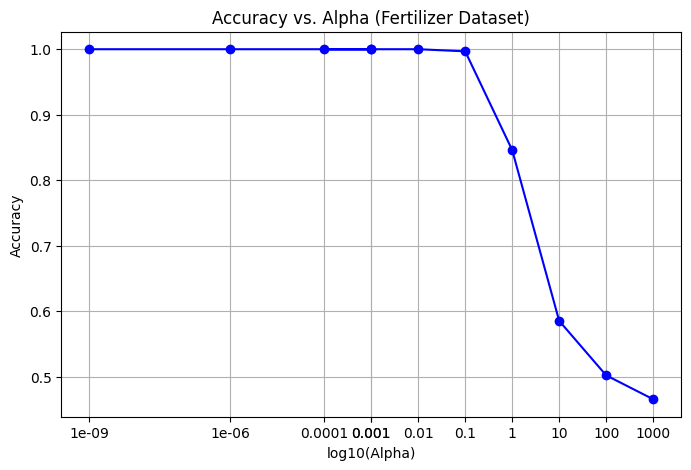

In [13]:
plt.figure(figsize=(8, 5))
plt.plot([np.log10(a) for a in alpha_values], alpha_accuracies, marker='o', color='blue')
plt.xlabel('log10(Alpha)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Alpha (Fertilizer Dataset)')
plt.xticks([np.log10(a) for a in alpha_values], labels=[str(a) for a in alpha_values])
plt.grid(True)
plt.show()

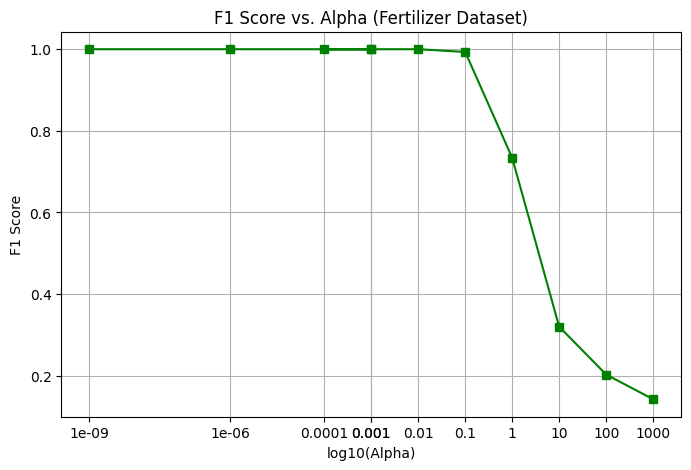

In [14]:
plt.figure(figsize=(8, 5))
plt.plot([np.log10(a) for a in alpha_values], alpha_f1_scores, marker='s', color='green')
plt.xlabel('log10(Alpha)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Alpha (Fertilizer Dataset)')
plt.xticks([np.log10(a) for a in alpha_values], labels=[str(a) for a in alpha_values])
plt.grid(True)
plt.show()